In [1]:
import cupy as np
import pyDR as DR
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [2]:
tf=2000
molsys=DR.MolSys('/home/mlehner/DynamicDetector/Frames_Theory_archive/HETs_Ile254.pdb',
                 '/home/mlehner/DynamicDetector/Frames_Theory_archive/HETs_Ile254.xtc',
                 tf=tf)
#molsys=DR.MolSys('/Users/albertsmith/Documents/GitHub.nosync/Frames_Theory_archive/HETs_ILE254.pdb',
#              '/Users/albertsmith/Documents/GitHub.nosync/Frames_Theory_archive/HETs_ILE254.xtc',
#              tf=tf)
select=DR.MolSelect(molsys)

In [3]:
frames=list()
frames.append({'Type':'methylCC','Nuc':'ivlal','sigma':0})
frames.append({'Type':'side_chain_chi','Nuc':'ivlal','n_bonds':1,'sigma':0})
frames.append({'Type':'side_chain_chi','Nuc':'ivlal','n_bonds':2,'sigma':0})

"Frames with post-process smoothing"
frames.append({'Type':'hops_3site','Nuc':'ivlal','sigma':5})
frames.append({'Type':'methylCC','Nuc':'ivlal','sigma':5})
frames.append({'Type':'chi_hop','Nuc':'ivlal','n_bonds':1,'sigma':50})
frames.append({'Type':'side_chain_chi','Nuc':'ivlal','n_bonds':1,'sigma':50})
frames.append({'Type':'chi_hop','Nuc':'ivlal','n_bonds':2,'sigma':50})
frames.append({'Type':'side_chain_chi','Nuc':'ivlal','n_bonds':2,'sigma':50})

In [4]:
select.select_bond(Nuc='ivlal')

In [5]:
fr_obj=DR.Frames.FrameObj(select)

In [6]:
fr_obj.tensor_frame(sel1=1,sel2=2)

In [7]:
for f in frames:fr_obj.new_frame(**f)

In [8]:
fr_obj.load_frames(n=-1)

Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed


In [9]:
fr_obj.post_process()

Applying default post processing (only active for frames that define their own post processing)


In [10]:
include=np.zeros([3,9],dtype=bool)
include[0][:3]=True  
include[1][[4,6,8]]=True
include[2][3:]=True

In [11]:
t=np.arange(tf>>1)*.005

In [12]:
data=fr_obj.frames2data(mode='full')

In [13]:
import pyDR
from pyDR.Project import Project
proj=Project('/home/mlehner/pyDR/pyDR/test_project.nosync',create=True)


for d in data:proj.append_data(d)
proj[0].detect.r_no_opt(10)
proj.fit(bounds=False)
proj['no_opt'][0].detect.r_auto(5)
proj['no_opt'].fit()


Fitted 12 data objects


/home/mlehner/pyDR/pyDR/Sens/Detector.py:187: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  method='interior-point',options={'disp':False})['x']
/home/mlehner/pyDR/pyDR/Sens/Detector.py:187: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  method='interior-point',options={'disp':False})['x']
/home/mlehner/anaconda3/envs/pyDR/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.02413e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Fitted 12 data objects


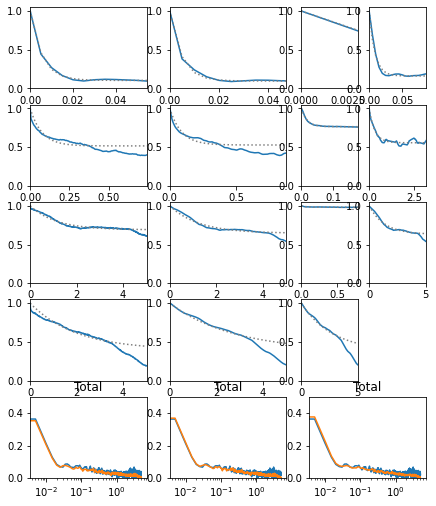

In [15]:
titles=[['Methyl rot.',r'$\chi_2$ rot.',r'$\chi_1$ rot.',r'C$\alpha$-C$\beta$ motion','Total'],
        ['Methyl rot.',r'$\chi_2$ rot.',r'$\chi_1$ rot.',r'C$\alpha$-C$\beta$ motion','Total'],
        ['Methyl lib.','Methyl hop.',r'$\chi_2$ lib.',r'$\chi_2$ hop.',
          r'$\chi_1$ lib.',r'$\chi_1$ hop.',r'C$\alpha$-C$\beta$ motion','Total']]
fig=plt.figure('Methyl Dynamics')
fig.clear()
fig.set_size_inches([10.27,  9.03])
ax=[]
ax.append([fig.add_subplot(5,3,k+1) for k in range(0,15,3)])
ax.append([fig.add_subplot(5,3,k+1) for k in range(1,15,3)])
ax.append([fig.add_subplot(5,6,k+1) for k in [4,5,10,11,16,17,22]])
ax[-1].append(fig.add_subplot(5,3,15))

for a0,t0 in zip(ax,titles):
    for a, title in zip(a0,t0):
        a.set_title(title)

for inc,ax0 in zip(include,ax):
    out=fr_obj.frames2ct(include=inc,mode='full')
    
    for ct,a in zip(out['ct_finF'],ax0):
        a.cla()
        a.plot(t,ct.mean(0)[:tf>>1])
        a.set_ylim([0,1.05])
        S2=ct.mean(0)[tf>>2:tf>>1].mean()
        b=np.argwhere(ct.mean(0)-S2<0)[0,0]
#        tc0=np.max([.001,((ct.mean(0)[:b]-S2)/(1-S2)).sum()*.005])
        tc0=t[np.argmin(np.abs((ct.mean(0)[:b]-S2)/(1-S2)-np.exp(-1)))]
        fun=lambda x:(((x[0]+(1-x[0])*np.exp(-t[:b]/x[1]))-ct.mean(0)[:b])**2).sum()
        S2,tc=least_squares(fun,[S2,tc0]).x
        a.plot(t,S2+(1-S2)*np.exp(-t/tc),color='grey',linestyle=':')
        a.set_xlim([0,np.min([10*tc,fr_obj.t[tf>>1]])])
    ax0[-1].semilogx(out['t'][:tf>>1],out['ct'].mean(0)[:tf>>1])
    ax0[-1].semilogx(out['t'][:tf>>1],out['ct_prod'].mean(0)[:tf>>1])
    ax0[-1].set_ylim([0,.5])
    
fig.set_size_inches([180/25.4,220/25.4])
plt.savefig("/home/mlehner/pyDR/out_figures/methyl_test.pdf")
plt.show()